# **German Credit Data**
Final project for the CAS in Applied Data Science - University of Bern

7 August 2022 – Atdhe Panxhaj, Elias Bounatirou

## Introduction

In our study we explore the Statlog German Credit Data dataset in a derived and partly simplified or shortened form available from Kaggle (henceforth *Simpl-GermCred*; https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk?select=german_credit_data.csv). The original dataset has been published on UCI (see the file `german.data` at https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/; cf. also the additional information at https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)). Both dataset versions classify "people described by a set of attributes as good or bad credit risks". Using Simpl-GermCred, we will try in this study to apply different machine learning algorithms to predict if a person is a good credit customer or if he or she presents a credit risk. We will use the classification algorithms Logistic Regression (LR), Random Forest (RF), Support Vector Machine (SVM) and a fully connected  neural network classifier (FCNN). 

The main goal of this study is to demonstrate how a so-called *Monte Carlo cross-validation* approach can be applied in order to assess and compare all types of machine learning models by determining 95% confidence intervals for a selected performance measure. This measure will be the accuracy score in our case. It appears that the Monte Carlo cross-validation technique is until now, unfortunately, not very popular among data scientists, and it should receive more attention.

Since the focus of our project is to show how to apply the Monte Carlo cross-validation approach we will keep the exploratory data analysis of Simpl-GermCred to a minimum. 

At the same time, it should be noted that the paper http://www1.beuth-hochschule.de/FB_II/reports/Report-2019-004.pdf (section 4.2/ p. 7) points out errors that according to the author of the paper have been made when converting the original dataset to a dataset very similar to the derived version used in this study. This simplified dataset can be found at https://www.kaggle.com/datasets/uciml/german-credit. We tried to verify whether Simpl-GermCred has the mistakes in question, too, but it turned out that the errors do not apply or do not apply any longer to the dataset version this analysis is based on.

In addition, one should mention that it also appears to be necessary to take into account the description given for the original dataset (https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). The reason is that only this allows one to fully understand what the features and their values, contained in Simpl-GermCred, stand for. Simpl-GermCred itself, unfortunately, lacks any kind of description. Comparing the data of Simpl-GermCred with the original dataset and its description  also makes it possible to correct a number of inconsistencies in Simpl-GermCred we could nevertheless identify.

## Loading the Libraries

In [202]:
colab = True 
if colab:
    %tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import tensorflow as tf
%load_ext tensorboard
%matplotlib inline

from sklearn.model_selection import train_test_split

# import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Scaling
from sklearn.preprocessing import StandardScaler

# import metrics to compute accuracy
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, recall_score

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [204]:
print(tf.__version__)

2.8.2


## Loading the Data
The dataset was downloaded from Kaggle and then stored on a publicly accessible repository on GitHub (https://github.com/ebouna/module-7-CAS-ADS). The data set is loaded from this GitHub repository:

In [205]:
if colab:
    path = os.path.abspath('.')+'/german_credit_data.csv'
    print(path)
    url = 'https://raw.githubusercontent.com/ebouna/module-7-CAS-ADS/main/german_credit_data.csv' # raw version must be read in!
    p = tf.keras.utils.get_file(path, url)

/content/german_credit_data.csv


We load the data into a pandas dataframe to further process the features and their values:

In [206]:
df = pd.read_csv(url)

## Overview of the Data (Exploratory Data Analysis) 
Below we have a first look at the dataset `df`:



In [207]:
df

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


The first column of the dataframe `df` can be deleted. It is virtually superfluous because it only repeats the information contained in the index as becomes obvious from the following lines of code:

In [208]:
df1 = df.reset_index() # Convert index into a column named 'index'
df1

,index,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,996,40,male,3,own,little,little,3857,30,car,good
997,997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


We can now compare the `index` column in the dataframe `df1` we have just created with the following unnamed column in `df1` containing the superfluous information:

In [209]:
df1.iloc[:,0].equals(df1.iloc[:,1]) 

True

As can be seen, the index values and the values in the unnamed column of `df` is identical.

In [210]:
# Drop first column of dataframe df
df = df.iloc[: , 1:]

In addition, some of the columns names should be renamed to be more pythonic. Note that the name of the column `Saving accounts` in Simpl-GermCred is linguistically erroneous. It should be `Savings account` (see also the similar name in the description of the original dataframe: https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)).

In [211]:
df = df.rename(columns={'Saving accounts': 'Savings_account', 'Checking account': 'Checking_account', 'Credit amount':'Credit_amount'})

In [212]:
df

,Age,Sex,Job,Housing,Savings_account,Checking_account,Credit_amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


The dataset to be analysed has 1000 entries and contains observations for 10 variables:

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Savings_account   817 non-null    object
 5   Checking_account  606 non-null    object
 6   Credit_amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


These various variables and the data contained in them are given below. On the meaning of the variables see also https://www.kaggle.com/datasets/uciml/german-credit as well as the original dataset and its description https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data). Cf. in addition the preceding line of code in this notebook.

- Age (numeric)
- Sex (text: male, female)


In [214]:
df.Sex.unique()

array(['male', 'female'], dtype=object)

- Job (numeric: 0 - unemployed/ unskilled - non-resident, 1 - unskilled - resident, 2 - skilled employee/ official, 3 - management/ self-employed/ highly qualified employee/ officer). Note that the `Job` categories have obviously been encoded as ordinal data.

In [215]:
df.Job.unique()

array([2, 1, 3, 0])

- Housing (text: own, rent, free)

In [216]:
df.Housing.unique()

array(['own', 'free', 'rent'], dtype=object)

- Savings account (text: little, moderate, quite rich, rich)

In [217]:
df.Savings_account.unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

`Savings account` contains values corresponding to the textual entries `little`, `moderate`, `quite rich`, `rich`. However, in addition it also has `NaN` values. As can be seen from the description of the original dataset, these `NaN` values correspond to a fifth category in this feature, to the category `unknown/ no savings account`.

- Checking account

In [218]:
df.Checking_account.unique()

array(['little', 'moderate', nan, 'rich'], dtype=object)

`Checking account` has the textual values `little`, `moderate`, `quite rich`. Apart from this there are also `NaN` values. These correspond to the category `no checking account` in the original dataframe. Note that at https://www.kaggle.com/datasets/uciml/german-credit `Checking account` is wrongly described as a numeric variable.

The `NaN` values of the `Savings account` and `Checking account` variables are treated in a separate section of our analysis below (see the section "Correcting the `NaN` values in the `Savings account` and `Checking account` variables ").

- Credit amount (numeric, in DM)

- Duration (numeric, in month)

- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [219]:
df.Purpose.unique()

array(['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others'], dtype=object)

- Risk (text: good, bad)

In [220]:
df.Risk.unique()

array(['good', 'bad'], dtype=object)

For the number of rows with `NaN` values in our dataset, cf. also:  

In [221]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Savings_account     183
Checking_account    394
Credit_amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

The percentage of rows with `NaN` can be seen from the following:

In [222]:
100 * df.isnull().sum() / len(df)

Age                  0.0
Sex                  0.0
Job                  0.0
Housing              0.0
Savings_account     18.3
Checking_account    39.4
Credit_amount        0.0
Duration             0.0
Purpose              0.0
Risk                 0.0
dtype: float64

The `Risk` variable will be the label in our classification. It should be mentioned that the relationship between the values `good` and `bad`, i.e. `Good customer` and `Bad customer` in terms of the credit risk for the bank, is imbalanced: 

In [223]:
# Helper function to generate pct for pie chart
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  \n(n={v:d})'.format(p=pct,v=val)
    return my_autopct

Text(0.5, 1.0, 'Good Customer/ Bad Customer Proportion')

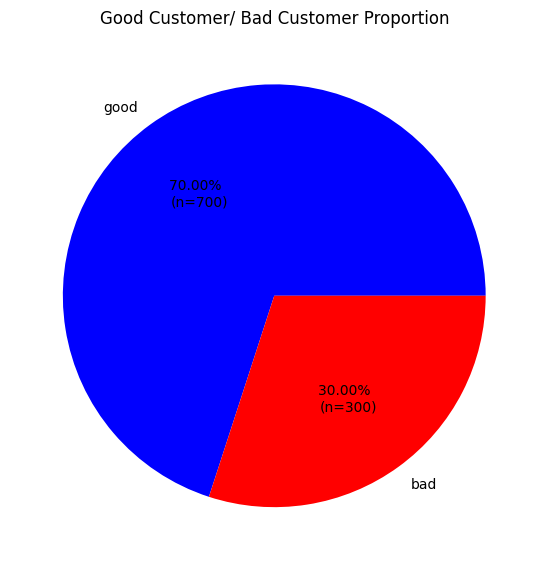

In [224]:
labels=['good', 'bad']
colors={'good':'b', 'bad':'r'}

plt.figure(figsize=(10,7),dpi=100)
good_bad_repartition = df.value_counts(['Risk'])
plt.pie(good_bad_repartition,labels=labels, colors=[colors[key] for key in labels], autopct=make_autopct(good_bad_repartition))

plt.title('Good Customer/ Bad Customer Proportion')

As we are faced with imbalanced data we should take this into consideration when building the models. Thus, we will be specifying `stratify=y` when doing the train-test split with `scikit-learn`.  

## Feature Engineering

### Correcting the `NaN` Values in the `Savings account` and `Checking account` Variables 

The `NaN` values in the `Savings account` feature are out of place as pointed out above. They will be converted to the value `unk_no_sav_acc`, representing the mixed category `unknown/ no savings account`. We are aware of the problem that the information `unknown savings account` which is united here with the information `no savings account` is virtually a lack of information. As this mixed category also comprises persons without savings accounts, we cannot predict values for the `NaN` values from the rest of the categories of the `Savings account` feature. For this would mean filling in the values `little`, `moderate`, `quite rich`, `rich` also for observations where there may have been no savings account at all. Note that another way to deal with the whole issue would be to completely exclude the `Savings account` variable from the dataset. Yet another option in this problematic case would be to delete the rows where `Savings account` feature contains `NaN` values:

In [225]:
df['Savings_account'].fillna('unk_no_sav_acc', inplace=True)
df

,Age,Sex,Job,Housing,Savings_account,Checking_account,Credit_amount,Duration,Purpose,Risk
0,67,male,2,own,unk_no_sav_acc,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


Dealing with the `NaN` values of the `Checking account` feature is easier than with those of the `Savings account` variable: from the description of the original dataset, we can see that in the case of the `Checking account` variable, `NaN` corresponds to the value `no checking account`, which is still a valuable information. For that reason, `NaN` values of the `Checking account` feature will be replaced by `no_check_acc` representing the category `no checking account`:

In [226]:
df['Checking_account'].fillna('no_check_acc', inplace=True)

In [227]:
df

,Age,Sex,Job,Housing,Savings_account,Checking_account,Credit_amount,Duration,Purpose,Risk
0,67,male,2,own,unk_no_sav_acc,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,no_check_acc,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,no_check_acc,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,no_check_acc,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


### Dealing with Categorical Data
We replace the columns with categorical variables by columns with dummy variables:

In [228]:
sex = pd.get_dummies(df['Sex'], drop_first=True,  prefix="Sex")
housing = pd.get_dummies(df['Housing'], drop_first=True,  prefix="Housing") 
sav_acc = pd.get_dummies(df['Savings_account'], drop_first=True,  prefix="Sav_acc")
check_acc = pd.get_dummies(df['Checking_account'], drop_first=True,  prefix="Check_acc") 
purpose = pd.get_dummies(df['Purpose'], drop_first=True,  prefix="Purp") 
risk = pd.get_dummies(df['Risk'], drop_first=True,  prefix="Risk")

We can now create a dataframe `X` containing the values of all the explanatory variables:

In [229]:
# independent/explanatory variables
X = pd.concat([df.Age, 
               sex, 
               df.Job, 
               housing, 
               sav_acc, 
               check_acc, 
               df.Credit_amount, 
               df.Duration, 
               purpose], 
               axis=1)

X.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
Age,67,22,49,45,53,35,53,35,61,28
Sex_male,1,0,1,1,1,1,1,1,1,1
Job,2,2,1,2,2,1,2,3,1,3
Housing_own,1,1,1,0,0,0,1,0,1,1
Housing_rent,0,0,0,0,0,0,0,1,0,0
Sav_acc_moderate,0,0,0,0,0,0,0,0,0,0
Sav_acc_quite rich,0,0,0,0,0,0,1,0,0,0
Sav_acc_rich,0,0,0,0,0,0,0,0,1,0
Sav_acc_unk_no_sav_acc,1,0,0,0,0,1,0,0,0,0
Check_acc_moderate,0,1,0,0,0,0,0,1,0,1


`X`comprises all in all 21 features:

In [230]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       1000 non-null   int64
 1   Sex_male                  1000 non-null   uint8
 2   Job                       1000 non-null   int64
 3   Housing_own               1000 non-null   uint8
 4   Housing_rent              1000 non-null   uint8
 5   Sav_acc_moderate          1000 non-null   uint8
 6   Sav_acc_quite rich        1000 non-null   uint8
 7   Sav_acc_rich              1000 non-null   uint8
 8   Sav_acc_unk_no_sav_acc    1000 non-null   uint8
 9   Check_acc_moderate        1000 non-null   uint8
 10  Check_acc_no_check_acc    1000 non-null   uint8
 11  Check_acc_rich            1000 non-null   uint8
 12  Credit_amount             1000 non-null   int64
 13  Duration                  1000 non-null   int64
 14  Purp_car                  1000 non-null  

## Defining the Dependent Variable

In [231]:
# dependent variable (Risk_good)
y = risk
y

,Risk_good
0,1
1,0
2,1
3,1
4,0
...,...
995,1
996,1
997,1
998,0


# Building the Models and Applying Monte Carlo Cross-Validation

Now we build the LR, RF, SVM and FCNN classifiers and apply the Monte Carlo Cross-Validation technique to assess them.

First, we deal with the LR, RF and SVM classifiers.
We create a list containing the LR, RF and SVM classifiers and another one with the names of the classifiers, which will be used later when the results are presented: 

In [232]:
models=[LogisticRegression(),RandomForestClassifier(),SVC()] 
print(models)
names=['LR','RF','SVM'] 
names

[LogisticRegression(), RandomForestClassifier(), SVC()]


['LR', 'RF', 'SVM']

In the following three cells, we start with Monte Carlo Cross-Validation. To do so, we convert `X` and `y` to numpy arrays and then create a for-loop. At each iteration (in our case there will be 500), we will have a new train-test split of the data, after which the data will be scaled and the three models, LR, RF and SVM, will be built. For each of the models the accuracy is calculated and eventually collected in the `result` list. 

In [233]:
X = X.to_numpy()

In [234]:
y = risk['Risk_good'].to_numpy()
y

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,

In [235]:
iteration=500
results = []
scaler = StandardScaler()
for i in range(0,iteration):

    accuracy = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

    # fit and transform the data
    X_train_scl = scaler.fit_transform(X_train)

    # transform the test data using the same values
    X_test_scl = scaler.transform(X_test)
    
    for model in models:
        model.fit(X_train_scl,y_train)
        y_pred=model.predict(X_test_scl)
        accuracy.append(accuracy_score(y_test, y_pred))
    results.append(accuracy)

Next, we look at the accuracy values we obtained for the three models. These results are given here in a dataframe called `accuracy_lr_rf_svm`, rounded in 3 decimals:

In [236]:
accuracy_lr_rf_svm = round(pd.DataFrame(np.array(results),columns=names), 3)
accuracy_lr_rf_svm

,LR,RF,SVM
0,0.717,0.713,0.713
1,0.750,0.780,0.777
2,0.693,0.737,0.720
3,0.737,0.737,0.740
4,0.680,0.683,0.707
...,...,...,...
495,0.737,0.717,0.713
496,0.743,0.717,0.740
497,0.707,0.737,0.710
498,0.760,0.760,0.760


Now we have a look at some statistics for the above dataframe:

In [237]:
statistics_lr_rf_svm = round(accuracy_lr_rf_svm.describe(percentiles=[0.025,0.25,0.5,0.75,0.975]), 3)
statistics_lr_rf_svm

,LR,RF,SVM
count,500.000,500.000,500.000
mean,0.731,0.735,0.731
std,0.019,0.019,0.017
min,0.673,0.677,0.673
2.5%,0.690,0.691,0.697
25%,0.719,0.723,0.720
50%,0.730,0.737,0.730
75%,0.743,0.747,0.743
97.5%,0.767,0.769,0.762
max,0.783,0.800,0.777


From the preceding statistical overview, we get the 95% confidence intervals for the accuracy score for each of the models.

In [238]:
statistics_lr_rf_svm.iloc[[4,8],:] #95% confidence intervals for accuracy score

,LR,RF,SVM
2.5%,0.690,0.691,0.697
97.5%,0.767,0.769,0.762


Next we carry out the same procedure for a fully connected neural network classifier (FCNN). First we import the necessary `tensorflow` libraries. We also use Early Stopping to prevent overfitting:

In [239]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [240]:
from tensorflow.keras.callbacks import EarlyStopping

In [241]:
model = Sequential()

model.add(Dense(units=21,activation = 'tanh')) # the 21 neurons correspond to the 21 explanatory variables fed in

# BINARY classification, so sigmoid is chosen
model.add(Dense(units=1,activation = 'sigmoid'))

In [242]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [243]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5) 

In [244]:
iteration=500
results = []

for i in range(0,iteration):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

    # fit and transform the data
    X_train_scl = scaler.fit_transform(X_train)

    # transform the test data using the same values
    X_test_scl = scaler.transform(X_test)
    
    hist = model.fit(x=X_train_scl, y=y_train,
                 epochs= 240, batch_size=32,
                 validation_data=(X_test_scl, y_test), 
                 callbacks=[early_stop],verbose=0
                 )
    results.append(hist.history['val_accuracy'][0]) 

In specifying `hist.history['val_accuracy'][0]` in the immediately preceding line of code, we make sure that from the 6 values contained in the array `hist.history['val_accuracy']` (because of the Early Stopping `patience` value chosen), we read out the first one, i.e. the best one. 

Now we look at the accuracy values obtained for the FCNN:

In [245]:
accuracy_fcnn = round(pd.DataFrame(np.array(results),columns=["FCNN"]), 3)
accuracy_fcnn

,FCNN
0,0.543
1,0.760
2,0.737
3,0.793
4,0.743
...,...
495,0.907
496,0.923
497,0.903
498,0.937


Now as similarly done when building the three preceding classifiers, we have a look at some statistics for the above dataframe `accuracy_fcnn` which we have just created:

In [246]:
statistics_fcnn=round(accuracy_fcnn.describe(percentiles=[0.025,0.25,0.5,0.75,0.975]),3)
statistics_fcnn

,FCNN
count,500.000
mean,0.863
std,0.055
min,0.543
2.5%,0.750
25%,0.823
50%,0.880
75%,0.907
97.5%,0.932
max,0.950


The dataframe below then combines the accuracy scores for all the four classifiers (model types) we want to compare:

In [247]:
accuracy_models= round(pd.concat([accuracy_lr_rf_svm,accuracy_fcnn],axis=1),3)
accuracy_models

,LR,RF,SVM,FCNN
0,0.717,0.713,0.713,0.543
1,0.750,0.780,0.777,0.760
2,0.693,0.737,0.720,0.737
3,0.737,0.737,0.740,0.793
4,0.680,0.683,0.707,0.743
...,...,...,...,...
495,0.737,0.717,0.713,0.907
496,0.743,0.717,0.740,0.923
497,0.707,0.737,0.710,0.903
498,0.760,0.760,0.760,0.937


We add the same statistical information for the preceding dataframe `accuracy_models` that we also provided before for dataframes with accuracy scores: 

In [248]:
statistics=round(pd.concat([statistics_lr_rf_svm,statistics_fcnn],axis=1),3)
statistics

,LR,RF,SVM,FCNN
count,500.000,500.000,500.000,500.000
mean,0.731,0.735,0.731,0.863
std,0.019,0.019,0.017,0.055
min,0.673,0.677,0.673,0.543
2.5%,0.690,0.691,0.697,0.750
25%,0.719,0.723,0.720,0.823
50%,0.730,0.737,0.730,0.880
75%,0.743,0.747,0.743,0.907
97.5%,0.767,0.769,0.762,0.932
max,0.783,0.800,0.777,0.950


The next table shows the 95% confidence interval for the accuracy score of all four classifiers investigated.

In [249]:
statistics.iloc[[4,8],:]

,LR,RF,SVM,FCNN
2.5%,0.690,0.691,0.697,0.750
97.5%,0.767,0.769,0.762,0.932


As we can see, the results of the FCNN prove to be the best while the other classifiers seem to perform worse. They have similar lower accuracy scores.